# Lab 6: Bayesian Regression & PyTorch
## A: *Bayesian Treatment of Linear Regression* 
## B: [*Linear Regression with PyTorch*](#partB)

### [Haiping Lu](http://staffwww.dcs.shef.ac.uk/people/H.Lu/) -  COM4509/6509 MLAI2019

### Part 6A: modified in Nov 2019 based on notebooks by Neil Lawrence [MLAI2015](http://inverseprobability.com/mlai2015/)
### Part 6B: based on the [SimplyDeep](https://github.com/haipinglu/SimplyDeep/) project I recently started

$$\newcommand{\inputScalar}{x}
\newcommand{\lengthScale}{\ell}
\newcommand{\mappingVector}{\mathbf{w}}
\newcommand{\gaussianDist}[3]{\mathcal{N}\left(#1|#2,#3\right)}
\newcommand{\gaussianSamp}[2]{\mathcal{N}\left(#1,#2\right)}
\newcommand{\zerosVector}{\mathbf{0}}
\newcommand{\eye}{\mathbf{I}}
\newcommand{\dataStd}{\sigma}
\newcommand{\dataScalar}{y}
\newcommand{\dataVector}{\mathbf{y}}
\newcommand{\dataMatrix}{\mathbf{Y}}
\newcommand{\noiseScalar}{\epsilon}
\newcommand{\noiseVector}{\mathbf{\epsilon}}
\newcommand{\noiseMatrix}{\mathbf{\Epsilon}}
\newcommand{\inputVector}{\mathbf{x}}
\newcommand{\kernelMatrix}{\mathbf{K}}
\newcommand{\basisMatrix}{\mathbf{\Phi}}
\newcommand{\basisVector}{\mathbf{\phi}}
\newcommand{\basisScalar}{\phi}
\newcommand{\expSamp}[1]{\left<#1\right>}
\newcommand{\expDist}[2]{\left<#1\right>_{#2}}
\newcommand{\covarianceMatrix}{\mathbf{C}}
\newcommand{\numData}{n}
\newcommand{\mappingScalar}{w}
\newcommand{\mappingFunctionScalar}{f}
\newcommand{\mappingFunctionVector}{\mathbf{f}}
\newcommand{\meanVector}{\boldsymbol{\mu}}
\newcommand{\meanScalar}{\mu}$$

# Part A: Bayesian Regression

## A1. The Bayesian Approach

The aim of this notebook is to study Bayesian approaches to regression. In the Bayesian approach we define a *prior* density over our parameters, $m$ and $c$ or more generally $\mathbf{w}$. This prior distribution gives us a range of expected values for our parameter *before* we have seen the data. The objective in Bayesian inference is to then compute the *posterior* density which is the effect on the density of having observed the data. 

In standard probability notation we write the **prior distribution** as,
$$p(\mathbf{w}),$$
so it is the *marginal* distribution for the parameters, i.e. the distribution we have for the parameters without any knowledge about the data. 

The **posterior distribution** is written as,
$$p(\mathbf{w}|\mathbf{y}, \mathbf{X}).$$
So the posterior distribution is the *conditional* distribution for the parameters given the data (which in this case consists of pairs of observations including response variables (or targets), $y_i$, and covariates (or inputs) $\mathbf{x}_i$, where we are allowing the inputs to be multivariate. 

The posterior is recovered from the prior using *Bayes' rule*. Which is simply a rewriting of the product rule. We can recover Bayes rule as follows. The product rule of probability tells us that the joint distribution is given as the product of the conditional and the marginal. Dropping the inputs from our conditioning for the moment we have,
$$p(\mathbf{w}, \mathbf{y})=p(\mathbf{y}|\mathbf{w})p(\mathbf{w}),$$
where we see we have related the joint density to the prior density and the **likelihood** from our previous investigation of regression,
$$p(\mathbf{y}|\mathbf{w}) = \prod_{i=1}^n\mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i, \sigma^2)$$
which arises from the assumption that our observation is given by
$$y_i = \mathbf{w}^\top \mathbf{x}_i + \epsilon_i.$$
In other words this is the Gaussian likelihood we have been fitting by minimizing the sum of squares. Have a look at Session 3 notebook as a reminder.

We've introduce the likelihood, but we don't have  relationship with the posterior, however, the product rule can also be written in the following way
$$p(\mathbf{w}, \mathbf{y}) = p(\mathbf{w}|\mathbf{y})p(\mathbf{y}),$$
where here we have simply used the opposite conditioning. We've already introduced the *posterior* density above. This is the density that represents our belief about the parameters *after* observing the data. This is combined with the **marginal likelihood**, sometimes also known as the evidence. It is the marginal likelihood, because it is the original likelihood of the data with the parameters marginalised, $p(\mathbf{y})$. Here it's conditioned on nothing, but in practice you should always remember that everything here is conditioned on things like model choice: which set of basis functions. Because it's a regression problem, its also conditioned on the inputs. Using the equality between the two different forms of the joint density  we recover
$$p(\mathbf{w}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{w})p(\mathbf{w})}{p(\mathbf{y})}$$
where we divided both sides by $p(\mathbf{y})$ to recover this result. Let's re-introduce the conditioning on the input locations (or covariates), $\mathbf{X}$ to write the full form of Bayes' rule for the regression problem. 
$$p(\mathbf{w}|\mathbf{y}, \mathbf{X}) = \frac{p(\mathbf{y}|\mathbf{w}, \mathbf{X})p(\mathbf{w})}{p(\mathbf{y}|\mathbf{X})}$$
where the posterior density for the parameters given the data is $p(\mathbf{w}|\mathbf{y}, \mathbf{X})$, the marginal likelihood is $p(\mathbf{y}|\mathbf{X})$, the prior density is $p(\mathbf{w})$ and our original regression likelihood is given by $p(\mathbf{y}|\mathbf{w}, \mathbf{X})$. It turns out that to compute the posterior the only things we need to do are define the prior and the likelihood. The other term on the right hand side can be computed by *the sum rule*. It is one of the key equations of Bayesian inference, the expectation of the likelihood under the prior, this process is known as marginalisation,
$$
p(\mathbf{y}|\mathbf{X}) = \int p(\mathbf{y}|\mathbf{w},\mathbf{X})p(\mathbf{w}) \text{d}\mathbf{w}
$$
The term marginalisation nicely interprets the description of the probability as the *marginal likelihood*, because it somewhat has the implication that the variable name has been removed, and (perhaps) written in the margin. Marginalisation of a variable goes from a likelihood where the variable is in place, to a new likelihood where **all possible values** of that variable (under the prior) have been **considered and weighted** in the integral. 

This implies that **all we need for specifying our model is to define the likelihood and the prior**. We already have our likelihood from our earlier discussion, so our focus now turns to the prior density.



## A2. The Prior Density and How to Sample from It

Let's assume that the prior density is given by a zero mean Gaussian, which is independent across each of the parameters, 
$$\mappingVector \sim \gaussianSamp{\zerosVector}{\alpha \eye}$$
In other words, we are assuming, for the prior, that each element of the parameters vector, $\mappingScalar_i$, was drawn from a Gaussian density as follows
$$\mappingScalar_i \sim \gaussianSamp{0}{\alpha}$$

Let's start by assigning the parameter of the prior distribution, which is the variance of the prior distribution, $\alpha$.

In [1]:
# set prior variance on w
alpha = 4.
# set the order of the polynomial basis set
order = 5
# set the noise variance
sigma2 = 0.01

### Generating samples from the model

A very important aspect of probabilistic modelling is to *sample* from your model to see what type of assumptions you are making about your data. In this case that involves a two stage process.

1. **Sample a candiate parameter vector from the prior.**
2. **Place the candidate parameter vector in the likelihood and sample functions conditiond on that candidate vector.**
3. **Repeat to try and characterise the type of functions you are generating.**

Given a prior variance (as defined above) we can now  sample from the prior distribution and combine with a basis set to see what assumptions we are making about the functions *a priori* (i.e. before we've seen the data). 

### Prepare the data and specify the model
Firstly we compute the basis function matrix. We will do it both for our training data, and for a range of prediction locations (`x_pred`). 

In [2]:
import numpy as np
import pods
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']
num_data = x.shape[0]
num_pred_data = 100 # how many points to use for plotting predictions
x_pred = np.linspace(1890, 2016, num_pred_data)[:, None] # input locations for predictions

If you have problem downloading the data, it is made available [here](Datasets\marathon_data.txt) as well for you to read in as `x` and `y` to proceed.

now let's build the basis matrices. We define the polynomial basis as follows.

In [3]:
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees

In [4]:
loc = 1950.
scale = 1.
degree = 5. 
Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
Phi = polynomial(x, degree=degree, loc=loc, scale=scale)


### Scaling Gaussian-distributed Variables

Now we will sample from the prior to produce a vector $\mappingVector$ and use it to plot a function which is representative of our belief *before* we fit the data. To do this we are going to use the properties of the Gaussian density and obtain a sample from a **standard normal** (mean=0, variance=1) using the function `np.random.normal`.

First, let's consider the case where we have one data point and one feature in our basis set. In otherwords $\mappingFunctionVector$ would be a scalar, $\mappingVector$ would be a scalar and $\basisMatrix$ would be a scalar. In this case we have 

$$\mappingFunctionScalar = \basisScalar \mappingScalar$$

If $\mappingScalar$ is drawn from a normal density, 

$$\mappingScalar \sim \gaussianSamp{\meanScalar_\mappingScalar}{c_\mappingScalar}$$

and $\basisScalar$ is a scalar value which we are given, then properties of the Gaussian density tell us that 

$$\basisScalar \mappingScalar \sim \gaussianSamp{\basisScalar\meanScalar_\mappingScalar}{\basisScalar^2c_\mappingScalar}$$

Let's test this out numerically. First we will draw 200 samples from a standard normal,

In [5]:
w_vec = np.random.normal(size=200)

We can compute the mean of these samples and their variance

In [6]:
print('w sample mean is ', w_vec.mean())
print('w sample variance is ', w_vec.var())

w sample mean is  -0.015533398508796616
w sample variance is  0.9855310190085198


These are close to zero (the mean) and one (the variance) as you'd expect. Now compute the mean and variance of the scaled version,

In [7]:
phi = 7
f_vec = phi*w_vec
print('True mean should be phi*0 = 0.')
print('True variance should be phi*phi*1 = ', phi*phi)
print('f sample mean is ', f_vec.mean())
print('f sample variance is ', f_vec.var())

True mean should be phi*0 = 0.
True variance should be phi*phi*1 =  49
f sample mean is  -0.10873378956157635
f sample variance is  48.29101993141748


If you increase the number of samples then you will see that the sample mean and the sample variance begin to converge towards the true mean and the true variance. Obviously adding an offset to a sample from `np.random.normal` will change the mean. So if you want to sample from a Gaussian with mean `mu` and standard deviation `sigma` one way of doing it is to sample from the standard normal and scale and shift the result, so to sample a set of $\mappingScalar$ from a Gaussian with mean $\meanScalar$ and variance $\alpha$,

$$w \sim \gaussianSamp{\meanScalar}{\alpha}$$

We can simply scale and offset samples from the *standard normal*.

In [8]:
mu = 4 # mean of the distribution
alpha = 2 # variance of the distribution
w_vec = np.random.normal(size=200)*np.sqrt(alpha) + mu
print('w sample mean is ', w_vec.mean())
print('w sample variance is ', w_vec.var())

w sample mean is  3.8655945794519457
w sample variance is  2.105396137460894


Here the `np.sqrt` is necesssary because we need to multiply by the standard deviation and we specified the variance as `alpha`. So scaling and offsetting a Gaussian distributed variable keeps the variable Gaussian, but it effects the mean and variance of the resulting variable. 

To get an idea of the overal shape of the resulting distribution, let's do the same thing with a histogram of the results. 

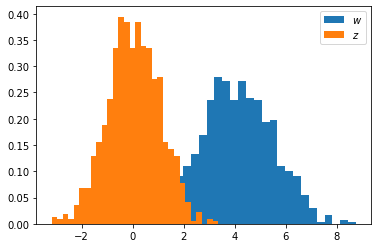

In [9]:
# First the standard normal
import matplotlib.pyplot as plt
%matplotlib inline
z_vec = np.random.normal(size=1000) # by convention, in statistics, z is often used to denote samples from the standard normal
w_vec = z_vec*np.sqrt(alpha) + mu
# plot normalized histogram of w, and then normalized histogram of z on top
plt.hist(w_vec, bins=30, density=True)
plt.hist(z_vec, bins=30, density=True)
plt.legend(('$w$', '$z$'))

Now **re-run** this histogram with 100,000 samples and check that the both histograms look qualitatively Gaussian.

### Sampling from the Prior by scaling a standard Gaussian

Let's use this way of constructing samples from a Gaussian to check what functions look like *a priori*. The process will be as follows. First, we sample a random vector of $K$ dimensional from `np.random.normal`. Then we scale it by $\sqrt{\alpha}$ to obtain a prior sample of $\mappingVector$.  

In [10]:
K = int(degree) + 1
z_vec = np.random.normal(size=K)
w_sample = z_vec*np.sqrt(alpha)
print(w_sample)

[ 0.00359736  1.01456336 -2.07247607 -0.84515819  0.44193957 -0.95048769]


Now we can combine our sample from the prior with the basis functions to create a function,

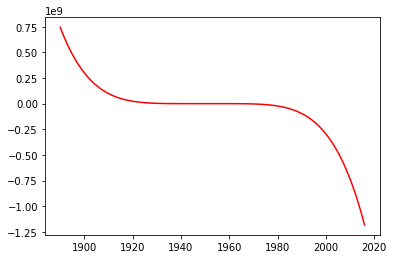

In [11]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

This shows the recurring problem with the polynomial basis. Our prior allows relatively large coefficients for the basis associated with high polynomial degrees. Because we are operating with input values of around 2000, this leads to output functions of very high values. The fix we have used for this before is to rescale our data before we apply the polynomial basis to it. Above, we set the scale of the basis to 1. Here let's set it to 100 and try again.

In [12]:
scale = 100.
Phi_pred = polynomial(x_pred, degree=degree, loc=loc, scale=scale)
Phi = polynomial(x, degree=degree, loc=loc, scale=scale)


Now we need to recompute the basis functions from above, 

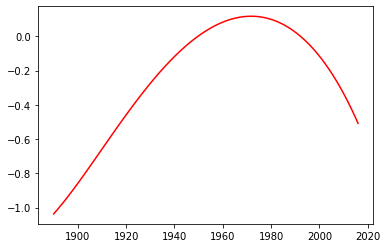

In [13]:
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')

Now let's loop through some samples and plot various functions as samples from this system,

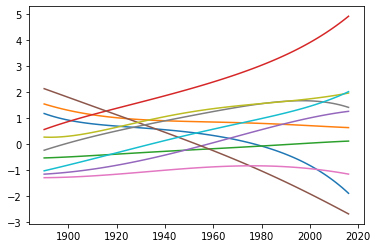

In [14]:
num_samples = 10
K = int(degree)+1
for i in range(num_samples):
    z_vec = np.random.normal(size=K)
    w_sample = z_vec*np.sqrt(alpha)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())


### Next: predicting the output 

The predictions for the mean output can now be computed. We want the **expected value of the predictions under the posterior distribution**. In matrix form, the predictions can be computed as

$$\mathbf{f} = \basisMatrix \mappingVector.$$

This involves a matrix multiplication between a fixed matrix $\basisMatrix$ and a vector $\mappingVector$ that is drawn from a distribution. Because $\mappingVector$ is drawn from a distribution, this imples that $\mappingFunctionVector$ should also be drawn from a distribution. There are two distributions we are interested in though. We have just been sampling from the *prior* distribution to see what sort of functions we get *before* looking at the data. In Bayesian inference, we need to **compute the posterior distribution and sample from that density**.

## A3. Bayesian Inference
The process of Bayesian inference involves combining the prior, $p(\mappingVector)$ with the likelihood, $p(\dataVector|\inputVector, \mappingVector)$ to form the posterior, $p(\mappingVector | \dataVector, \inputVector)$ through Bayes' rule,

$$p(\mappingVector|\dataVector, \inputVector) = \frac{p(\dataVector|\inputVector, \mappingVector)p(\mappingVector)}{p(\dataVector)}$$

We've looked at the samples for our function $\mappingFunctionVector = \basisMatrix\mappingVector$, which forms the mean of the Gaussian likelihood, under the prior distribution, i.e. we've sampled from $p(\mappingVector)$ and multiplied the result by the basis matrix. With the Baye's rule above, we can sample from the posterior density, $p(\mappingVector|\dataVector, \inputVector)$, and check that the new samples fit do correspond to the data, i.e. we can check that the updated distribution includes information from the data set. 

### Bayesian Inference in the Univariate Case


#### Prior Distribution

Let's consider only one model parameter $c$. For linear regression, consider a Gaussian prior on the intercept:
    $$c \sim \mathcal{N}(0, \alpha_1)$$

#### Stages to Derivation of the Posterior

-   Multiply likelihood by prior

    -   They are "exponentiated quadratics", the answer is always also
        an exponentiated quadratic because
        $$\exp(a^2)\exp(b^2) = \exp(a^2 + b^2)$$

-   Complete the square to get the resulting density in the form of
    a Gaussian.

-   Recognise the mean and (co)variance of the Gaussian. This is the
    estimate of the posterior.

#### Main Trick

$$p(c) = \frac{1}{\sqrt{2\pi\alpha_1}} \exp\left(-\frac{1}{2\alpha_1}c^2\right)$$
$$p(\mathbf{y}|\mathbf{x}, c, m, \sigma^2) = \frac{1}{\left(2\pi\sigma^2\right)^{\frac{n}{2}}} \exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^n(y_i - mx_i - c)^2\right)$$

$$p(c| \mathbf{y}, \mathbf{x}, m, \sigma^2) = \frac{p(\mathbf{y}|\mathbf{x}, c, m, \sigma^2)p(c)}{p(\mathbf{y}|\mathbf{x}, m, \sigma^2)}$$

$$p(c| \mathbf{y}, \mathbf{x}, m, \sigma^2) =  \frac{p(\mathbf{y}|\mathbf{x}, c, m, \sigma^2)p(c)}{\int p(\mathbf{y}|\mathbf{x}, c, m, \sigma^2)p(c) \text{d} c}$$

$$p(c| \mathbf{y}, \mathbf{x}, m, \sigma^2) \propto  p(\mathbf{y}|\mathbf{x}, c, m, \sigma^2)p(c)$$

$$\begin{aligned}
    \log p(c | \mathbf{y}, \mathbf{x}, m, \sigma^2) =&-\frac{1}{2\sigma^2} \sum_{i=1}^n(y_i-c - mx_i)^2-\frac{1}{2\alpha_1} c^2 + \text{const}\\
     = &-\frac{1}{2\sigma^2}\sum_{i=1}^n(y_i-mx_i)^2 -\left(\frac{n}{2\sigma^2} + \frac{1}{2\alpha_1}\right)c^2\\
    & + c\frac{\sum_{i=1}^n(y_i-mx_i)}{\sigma^2},
  \end{aligned}$$

complete the square of the quadratic form to obtain
$$\log p(c | \mathbf{y}, \mathbf{x}, m, \sigma^2) = -\frac{1}{2\tau^2}(c - \mu)^2 +\text{const},$$
where $\tau^2 = \left(n\sigma^{-2} +\alpha_1^{-1}\right)^{-1}$
and
$\mu = \frac{\tau^2}{\sigma^2} \sum_{i=1}^n(y_i-mx_i)$.


### Multivariate Bayesian Inference 



Compute the posterior distribution for multivariate $\mappingVector$, i.e., the posterior mean and *covariance*. This distribution is also Gaussian,

$$p(\mappingVector | \dataVector, \inputVector, \dataStd^2) = \mathcal{N}\left(\mappingVector|\meanVector_\mappingScalar, \covarianceMatrix_\mappingScalar\right)$$

with covariance, $\covarianceMatrix_\mappingScalar$, given by

$$\covarianceMatrix_\mappingScalar = \left(\dataStd^{-2}\basisMatrix^\top \basisMatrix + \alpha^{-1} \eye\right)^{-1}$$ 

whilst the mean is given by

$$\meanVector_\mappingScalar = \covarianceMatrix_\mappingScalar \dataStd^{-2}\basisMatrix^\top \dataVector$$

For *those interested*, the derivations are  available [here](https://nbviewer.jupyter.org/github/lawrennd/mlai2015/blob/master/week6.ipynb). Let's compute the posterior covariance and mean, then we'll sample from these densities to have a look at the posterior belief about $\mappingVector$ once the data has been accounted for. 


### Question 1

Compute the covariance for $\mathbf{w}$ given the training data (using the formulae above) and call the resulting variable `w_cov`. Compute the mean for $\mathbf{w}$ given the training data (using the formulae above) and call the resulting variable `w_mean`. Assume that $\sigma^2 = 0.01$

In [15]:
# Question 1 Answer Code
# Write code for you answer to this question in this box

# In this code @ is used instead of np.dot
sigma2 = 0.01
w_prec = 1/sigma2 * Phi.T @ Phi + 1/alpha * np.eye(K)
w_cov = np.linalg.inv(w_prec)
# print (w_cov)
w_mean = np.linalg.solve(w_prec, 1/sigma2*np.dot(Phi.T, y))
w_mean

array([[ 3.37086868],
       [-1.12665201],
       [ 1.60316386],
       [-1.32383453],
       [ 0.54615018],
       [-0.14329519]])

### Sampling from the Posterior

Earlier, we were able to sample the prior values for the mean *independently* from a Gaussian using `np.random.normal` and scaling the result. However, observing the data *correlates* the parameters. Recall this from the first lab where we had a correlation between the offset, $c$ and the slope $m$ which caused such problems with the coordinate ascent algorithm. We need to sample from a *correlated* Gaussian. For this we can use `np.random.multivariate_normal`.

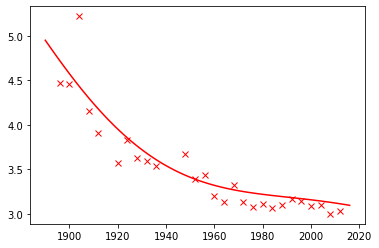

In [16]:
w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
f_sample = np.dot(Phi_pred,w_sample)
plt.plot(x_pred.flatten(), f_sample.flatten(), 'r-')
plt.plot(x, y, 'rx') # plot data to show fit.

Now let's sample several functions and plot them all to see how the predictions fluctuate.

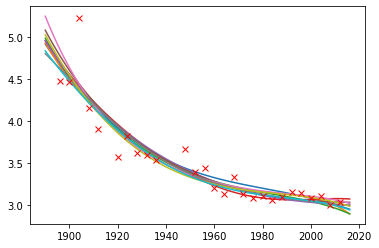

In [17]:
for i in range(num_samples):
    w_sample = np.random.multivariate_normal(w_mean.flatten(), w_cov)
    f_sample = np.dot(Phi_pred,w_sample)
    plt.plot(x_pred.flatten(), f_sample.flatten())
plt.plot(x, y, 'rx') # plot data to show fit.

This gives us an idea of what our predictions are. These are the predictions that are consistent with data and our prior. Try plotting different numbers of predictions. You can also try plotting beyond the range of where the data is and see what the functions do there. 

Rather than sampling from the posterior each time to compute our predictions, it might be better if we just summarised the predictions by the expected value of the output funciton, $f(x)$, for any particular input. If we can get formulae for this we don't need to sample the values of $f(x)$ we might be able to compute the distribution directly. Fortunately, in the Gaussian case, we can use properties of multivariate Gaussians to compute both the mean and the variance of these samples.

### Properties of Gaussian Variables

Gaussian variables have very particular properties, that many other densities don't exhibit. Perhaps foremost amoungst them is that the sum of any Gaussian distributed set of random variables also turns out to be Gaussian distributed. This property is much rarer than you might expect.

#### Sum of Gaussian-distributed Variables

The sum of Gaussian random variables is also Gaussian, so if we have a random variable $y_i$ drawn from a Gaussian density with mean $\meanScalar_i$ and variance $\dataStd^2_i$, 

$$y_i \sim \gaussianSamp{\meanScalar_i}{\dataStd^2_i}$$

Then the sum of $K$ independently sampled values of $y_i$ will be drawn from a Gaussian with mean $\sum_{i=1}^K \mu_i$ and variance $\sum_{i=1}^K \dataStd_i^2$,


$$\sum_{i=1}^K y_i \sim \gaussianSamp{\sum_{i=1}^K \meanScalar_i}{\sum_{i=1}^K \dataStd_i^2}.$$

Let's try that experimentally. First let's generate a vector of samples from a standard normal distribution, $z \sim \gaussianSamp{0}{1}$,  then we will scale and offset them, then keep adding them into a vector `y_vec`.

#### Sampling from Gaussians and Summing Up

In [18]:
K = 10 # how many Gaussians to add.
num_samples = 1000 # how many samples to have in y_vec
mus = np.linspace(0, 5, K) # mean values generated linearly spaced between 0 and 5
sigmas = np.linspace(0.5, 2, K) # sigmas generated linearly spaced between 0.5 and 2
y_vec = np.zeros(num_samples)
for mu, sigma in zip(mus, sigmas):
    z_vec = np.random.normal(size=num_samples) # z is from standard normal
    y_vec += z_vec*sigma + mu # add to y z*sigma + mu

# now y_vec is the sum of each scaled and off set z.
print('Sample mean is ', y_vec.mean(), ' and sample variance is ', y_vec.var())
print('True mean should be ', mus.sum())
print('True variance should be ', (sigmas**2).sum(), ' standard deviation ', np.sqrt((sigmas**2).sum())) 

Sample mean is  24.97769756121868  and sample variance is  17.182114311553992
True mean should be  25.0
True variance should be  17.916666666666664  standard deviation  4.232808366400098


Of course, we can histogram `y_vec` as well.

/home/nvpiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


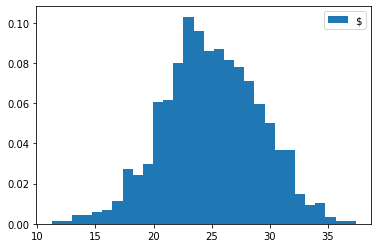

In [19]:
plt.hist(y_vec, bins=30, normed=True)
plt.legend('$y$')

### Matrix Multiplication of Gaussian Variables

We are interested in what our model is saying about the sort of functions we are observing. The fact that summing of Gaussian variables leads to new Gaussian variables, and scaling of Gaussian variables *also* leads to Gaussian variables means that matrix multiplication (which is just a series of sums and scales) also leads to Gaussian densities. Matrix multiplication is just adding and scaling together, in the formula, $\mappingFunctionVector = \basisMatrix \mappingVector$ we can extract the first element from $\mappingFunctionVector$ as

$$\mappingFunctionScalar_i = \basisVector_i^\top \mappingVector$$

where $\basisVector_i$ is a column vector from the $i$th row of $\basisMatrix$ and $\mappingFunctionScalar_i$ is the $i$th element of $\mappingFunctionVector$. This vector inner product itself merely implies that 

$$\mappingFunctionScalar_i = \sum_{j=1}^K \mappingScalar_j \basisScalar_{i, j}$$

and if we now say that $\mappingScalar_i$ is Gaussian distributed, then because a scaled Gaussian is also Gaussian, and because a sum of Gaussians is also Gaussian, we know that $\mappingFunctionScalar_i$ is also Gaussian distributed. It merely remains to work out its mean and covariance. The results are below and the derviations follow. For those interested, the derivations are  available [here](https://nbviewer.jupyter.org/github/lawrennd/mlai2015/blob/master/week6.ipynb).

The expectation under the prior is given by

$$\expDist{\mappingFunctionVector}{\gaussianDist{\mappingVector}{\zerosVector}{\alpha\eye}} = \zerosVector$$

and the covariance is 

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\zerosVector}{\alpha \eye}} = \alpha \basisMatrix \basisMatrix^\top$$


### Compute the Marginal Likelihood

Since our observed output, $\dataVector$, is given by a noise corrupted variation of $\mappingFunctionVector$, the final distribution for $\dataVector$ is given as 

$$\dataVector = \mappingFunctionVector + \noiseVector$$

where the noise, $\noiseVector$, is sampled from a Gaussian density: $\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2\eye}$. So, in other words, we are taking a Gaussian distributed random value $\mappingFunctionVector$,

$$\mappingFunctionVector \sim \gaussianSamp{\zerosVector}{\alpha\basisMatrix\basisMatrix^\top}$$

and adding to it another Gaussian distributed value, $\noiseVector \sim \gaussianSamp{\zerosVector}{\dataStd^2\eye}$, to form our data observations, $\dataVector$. Once again the sum of two (multivariate) Gaussian distributed variables is also Gaussian, with a mean given by the sum of the means (both zero in this case) and the covariance given by the sum of the covariances. So we now have that the marginal likelihood for the data, $p(\dataVector)$ is given by

$$p(\dataVector) = \gaussianDist{\dataVector}{\zerosVector}{\alpha \basisMatrix \basisMatrix^\top + \dataStd^2\eye}$$

This is our *implicit* assumption for $\dataVector$ given our prior assumption for $\mappingVector$.

### Computing the Mean and Error Bars of the Functions

These ideas together, now allow us to compute the mean and error bars of the predictions. The mean prediction, before corrupting by noise is given by,
$$
\mathbf{f} = \boldsymbol{\Phi}\mathbf{w}
$$
in matrix form. This gives you enough information to compute the predictive mean. 

### Question 2

Compute the predictive mean for the function at all the values of the basis function given by `Phi_pred`. Call the vector of predictions `f_pred_mean`. Plot the predictions alongside the data. We can also compute what the training error was. Use the output from your model to compute the predictive mean, and then compute the sum of squares error of that predictive mean.
$$
E = \sum_{i=1}^n (y_i - \langle f_i\rangle)^2
$$
where $\langle f_i\rangle$ is the expected output of the model at point $x_i$.

The error is:  1.0836499593059874


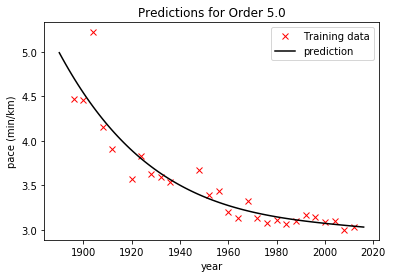

In [20]:
# Question 2 Answer Code
# Write code for you answer to this question in this box

# compute mean under posterior density
f_pred_mean = Phi_pred @ w_mean

# plot the predictions
plt.plot(x, y, 'rx', label='Training data')
plt.plot(x_pred, f_pred_mean,'black', label='prediction')
plt.legend()
ax = plt.gca()
ax.set_title('Predictions for Order ' + str(degree))
ax.set_xlabel('year')
ax.set_ylabel('pace (min/km)')

# compute mean at the training data and sum of squares error
f_mean = Phi @ w_mean
sum_squares = np.sum((y - f_mean) ** 2)
print('The error is: ', sum_squares)

### Computing Error Bars

Finally, we can compute error bars for the predictions. The error bars are the standard deviations of the predictions for $\mappingFunctionVector=\basisMatrix\mappingVector$ under the posterior density for $\mappingVector$. The standard deviations of these predictions can be found from the variance of the prediction at each point. Those variances are the diagonal entries of the covariance matrix. We've already computed the form of the covariance under Gaussian expectations (see the derivations [here](https://nbviewer.jupyter.org/github/lawrennd/mlai2015/blob/master/week6.ipynb)), 

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector}{\covarianceMatrix}} = \basisMatrix\covarianceMatrix \basisMatrix^\top$$

which under the posterior density is given by

$$\text{cov}\left(\mappingFunctionVector\right)_{\gaussianDist{\mappingVector}{\meanVector_w}{\covarianceMatrix_w}} = \basisMatrix\covarianceMatrix_w \basisMatrix^\top$$

###  Question 3

The error bars are given by computing the standard deviation of the predictions, $f$. For a given prediction $f_i$ the variance is $\text{var}(f_i) = \langle f_i^2\rangle - \langle f_i \rangle^2$. This is given by the diagonal element of the covariance of $\mathbf{f}$,
$$
\text{var}(f_i) = \boldsymbol{\phi}_{i, :}^\top \mathbf{C}_w \boldsymbol{\phi}_{i, :}
$$
where $\boldsymbol{\phi}_{i, :}$ is the basis vector associated with the input location, $\mathbf{x}_i$.

Plot the mean function and the error bars for your basis.

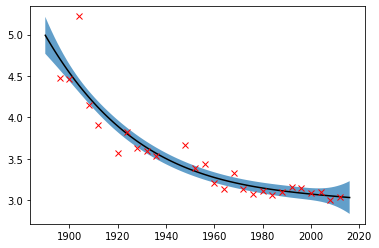

In [21]:
# Question 3 Answer Code
# Write code for you answer to this question in this box

# Compute variance at function values
f_pred_var = np.diag(Phi_pred @ w_cov @ Phi_pred.T)
f_pred_std = np.sqrt(f_pred_var)

# plot the mean and error bars at 2 standard deviations above and below the mean
plt.plot(x_pred, f_pred_mean, 'black')
plt.plot(x, y, 'rx')
# plt.errorbar(x_pred, f_pred_mean, f_pred_std)
plt.fill_between(np.squeeze(x_pred), 
                 np.squeeze(f_pred_mean) - 2*f_pred_std, np.squeeze(f_pred_mean) + 2*f_pred_std, alpha=0.7)

# <a id='partB'></a>Part B: Linear Regression with PyTorch


## Objective

* To perform linear regression using PyTorch for understanding the link between linear models and neural networks.

**Suggested reading**: 
* What is PyTorch from [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)

#### Assumptions: basic python programming and [Anaconda](https://anaconda.org/) installed.



## Why

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression) is a fundamental problem in statistics and machine learning. Using PyTorch, a deep learing library, to do linear regression will help bridge simple linear models with complex neural networks.

## 1. PyTorch Installation and Basics

### Install-1: direct installation (e.g., on your own machine with full installation right)

#### Install [PyTorch](https://github.com/pytorch/pytorch) via [Anaconda](https://anaconda.org/)
`conda install -c pytorch pytorch`

When you are asked whether to proceed, say `y`

#### Install [torchvision](https://github.com/pytorch/vision)
`conda install -c pytorch torchvision`

When you are asked whether to proceed, say `y`

### Install-2: Set up Anaconda Python environment (e.g., on a university desktop)

On a university desktop, you may not have permission to install new packages on the main environment of Anaconda. Please follow the instructions below to set up a new environment. This is also recommended if you have different python projects running that may require different environments.

Open a command line terminal.

**Create a new conda environment with Python 3.6**<br>
`conda create -n mlai19 python=3.6 anaconda`

**Activate the conda environment `mlai19`**<br>
`activate mlai19` (Windows)<br>
`source activate mlai19` (Mac/Linux)<br>
You will see `(mlai19)` on the left indciating your environment

**Install Pytorch and Torchvision** (non-CUDA/GPU version for simplicity)<br>
`conda install pytorch torchvision cpuonly -c pytorch`<br>
If you have GPU, install the GPU version with command at [here](https://pytorch.org/)

**Start Jupyter notebook server**: `jupyter notebook`

### Tensor
Optional: Go over the first two modules of [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py), *What is PyTorch* and *Autograd*

`torch.Tensor` is 
a multidimensional array data structure (array). You may check out the full list of [tensor types](http://pytorch.org/docs/master/tensors.html) and various [tensor operations](https://pytorch.org/docs/stable/torch.html).


### Computational Graph
A computation graph defines/visualises a sequence of operations to go from input to model output. 

Consider a linear regression model $\hat y = Wx + b$, where $x$ is our input, $W$ is a weight matrix, $b$ is a bias, and $\hat y$ is the predicted output. As a computation graph, this looks like:

![Linear Regression Computation Graph](https://imgur.com/IcBhTjS.png)

PyTorch dynamically build the computational graph, for example
![DynamicGraph.gif](https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif)

## B2. Linear Regression using PyTorch

Let us start right away with implementing linear regression in PyTorch to study PyTorch concepts closely. This part follows the [PyTorch Linear regression example](https://github.com/pytorch/examples/tree/master/regression) that trains a **single fully-connected layer** to fit a 4th degree polynomial.

### A synthetic linear regression problem

* Generate model parameters, weight and bias. The weight vector and bias are both tensors, 1D and 0D, respectively. 

In [22]:
import torch
import torch.nn.functional as F

POLY_DEGREE = 4
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

In [23]:
print(W_target)
print(b_target)

tensor([[-1.2963],
        [-7.5316],
        [ 2.3520],
        [ 1.6185]])
tensor([9.8674])


* Next, define a number of functions to generate the input (variables) and output (target/response). 

In [24]:
def make_features(x):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in range(1, POLY_DEGREE+1)], 1)

def f(x):
    """Approximated function."""
    return x.mm(W_target) + b_target.item()

def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

def get_batch(batch_size=32):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(batch_size)
    x = make_features(random)
    y = f(x)
    return x, y

* Define a simple(st) neural network, which is a **single fully connected** (FC) layer. See [`torch.nn.Linear`](https://pytorch.org/docs/master/nn.html#torch.nn.Linear)

In [25]:
fc = torch.nn.Linear(W_target.size(0), 1)
print(fc)

Linear(in_features=4, out_features=1, bias=True)


    This is a *network* with four input units, one output unit, with a bias term.
    
* Now generate the data. Let us try to get five pairs of (x,y) first to inspect.


In [26]:
sample_x, sample_y = get_batch(5)
print(sample_x)
print(sample_y)

tensor([[ 0.8315,  0.6914,  0.5749,  0.4780],
        [-0.5068,  0.2568, -0.1301,  0.0660],
        [ 0.9374,  0.8787,  0.8237,  0.7721],
        [ 1.6433,  2.7005,  4.4378,  7.2926],
        [-0.3138,  0.0985, -0.0309,  0.0097]])
tensor([[5.7081],
        [8.3908],
        [5.2213],
        [9.6391],
        [9.4754]])


    Take a look at the FC layer weights (randomly initialised)

In [27]:
print(fc.weight)

Parameter containing:
tensor([[ 0.0877, -0.2189, -0.0187, -0.2463]], requires_grad=True)


    Reset the gradients to zero, perform a forward pass to get prediction, and compute the loss

In [28]:
fc.zero_grad()
output = F.smooth_l1_loss(fc(sample_x), sample_y)
loss = output.item()
print(loss)

7.5685319900512695


    Random did not give a good prediction. Let us do a backpropagation and update model parameters with gradients.

In [29]:
output.backward() 
for param in fc.parameters():  
    param.data.add_(-0.1 * param.grad.data)

    Check the updated weights and respective loss

In [30]:
print(fc.weight)
output = F.smooth_l1_loss(fc(sample_x), sample_y)
loss = output.item()
print(loss)

Parameter containing:
tensor([[ 0.1396, -0.1264,  0.0948, -0.0739]], requires_grad=True)
6.9301323890686035


   * Now keep feeding more data until the loss is small enough. 

In [31]:
from itertools import count
for batch_idx in count(1):
    # Get data
    batch_x, batch_y = get_batch()

    # Reset gradients
    fc.zero_grad()

    # Forward pass
    output = F.smooth_l1_loss(fc(batch_x), batch_y)
    loss = output.item()

    # Backward pass
    output.backward()

    # Apply gradients
    for param in fc.parameters():
        param.data.add_(-0.1 * param.grad.data)

    # Stop criterion
    if loss < 1e-3:
        break


In [32]:
print('Loss: {:.6f} after {} batches'.format(loss, batch_idx))
print('==> Learned function:\t' + poly_desc(fc.weight.view(-1), fc.bias))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

Loss: 0.000860 after 685 batches
==> Learned function:	y = -1.36 x^4 -7.60 x^3 +2.38 x^2 +1.65 x^1 +9.89
==> Actual function:	y = -1.30 x^4 -7.53 x^3 +2.35 x^2 +1.62 x^1 +9.87


## B3. Exercises


* Change the [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions) to different choices and compare the results.
  
* Formulate another regression problem and solve it using `torch.nn`
* Compare the `torch.nn` solution against the closed-form solution
* Explore any other variations that you can think of to learn more


# Acknowledgement
Some part of this notebook is taken from the following sources

* [PyTorch tutorial from CSE446, University of Washington](https://courses.cs.washington.edu/courses/cse446/18wi/sections/section7/446_pytorch_tutorial.html)